## Variational Autoencoder for Image Generation
- 使用動漫人物圖片訓練VAE，可產生新人物圖片

In [936]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
import torch.optim as optim

In [937]:
preprocess = transforms.Compose([
    transforms.Resize((28,28)),
    transforms.ToTensor(), #0~255 -> 0~1
#     transforms.Normalize(  #0~1 -> -1~1   (x-mean)/std
#     mean=[0.5,0.5,0.5],
#     std=[0.5,0.5,0.5]
# )
])

In [938]:
dataset = ImageFolder('/home/0753115/data/DL_HW2/',transform=preprocess)

In [939]:
train_data=torch.utils.data.DataLoader(dataset, batch_size=128, num_workers=1, shuffle=True)

In [940]:
for i,data in enumerate(train_data, 0):
    inputs, _ = data
    break

In [941]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        #output_shape = floor[(image_shape-kernel_size+2*padding)/stride] + 1
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=2, padding=1) #in 28, out 13
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5, stride=2, padding=1) #in 13, out 6
        
        #output_shape = (input-1)*stride+outputpadding-2*padding+kernel_size
        self.deconv1 = nn.ConvTranspose2d(12, 6, kernel_size=5, stride=2, padding=1, bias=False) #in 6, out 13
        self.deconv2 = nn.ConvTranspose2d(6, 3, kernel_size=5, stride=2, padding=1, output_padding=1, bias=False) #in 13, out 28

        self.fc1 = nn.Linear(432,256)
        self.fc2m = nn.Linear(256,64)
        self.fc2v = nn.Linear(256,64)
        self.fc2 = nn.Linear(64,256)
        self.out = nn.Linear(256,432)
    
    def encode(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.reshape(-1,432)  #batch*(12*6*6)
        
        x = self.fc1(x)
        x = F.relu(x)
        mean = self.fc2m(x)
        var = self.fc2v(x)  # log_var
        return mean, var
    
    def sample_code(self, mean, var):
        std = (0.5*var).exp()
        noise = torch.randn_like(std)
        return mean+std.mul(noise)  # mul ->  elementwise product

    def decode(self, z):
        z = F.relu(self.fc2(z))
        z = F.relu(self.out(z)).view(-1,12,6,6) #(batch, channel, height, width)
        z = F.relu(self.deconv1(z))
        z = F.relu(self.deconv2(z))
        out = torch.tanh(z)
        return out
    
    def forward(self, x):
        mean, var = self.encode(x)
        z = self.sample_code(mean, var)
        out = self.decode(z)
        return out, z, mean, var

In [942]:
vae=VAE()
print(vae)

VAE(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (conv2): Conv2d(6, 12, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1))
  (deconv1): ConvTranspose2d(12, 6, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), bias=False)
  (deconv2): ConvTranspose2d(6, 3, kernel_size=(5, 5), stride=(2, 2), padding=(1, 1), output_padding=(1, 1), bias=False)
  (fc1): Linear(in_features=432, out_features=256, bias=True)
  (fc2m): Linear(in_features=256, out_features=64, bias=True)
  (fc2v): Linear(in_features=256, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=256, bias=True)
  (out): Linear(in_features=256, out_features=432, bias=True)
)


In [943]:
def vae_loss(reconstruct, x, mean, var):
#     bce = F.binary_cross_entropy(reconstruct, x, size_average=False)
    mse = F.mse_loss(reconstruct, x, size_average=False)
    KL = -0.5 * torch.sum(1 + var - mean**2 - var.exp())
    
    return mse, KL, mse+KL

In [944]:
optimizer = optim.Adam(vae.parameters())

epochs=range(100)
vae.train()
ELBO=[]
for epoch in epochs:
    print('epochs',epoch)
    running_loss=0
    
    for i,data in enumerate(train_data, 0):
        inputs, _ = data

        optimizer.zero_grad()
        out, z, mean, var = vae(inputs)
        
        #get training loss
        mse, kl, loss = vae_loss(out, inputs, mean, var)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()   
    ELBO.append(running_loss)
    print(running_loss,'\n')

epochs 0
63.416817370802164 

epochs 1
10.118825979530811 

epochs 2
9.404876843094826 

epochs 3
9.154107544571161 

epochs 4
9.029652323573828 

epochs 5
8.947440944612026 

epochs 6
8.912323266267776 

epochs 7
8.857210148125887 

epochs 8
8.837729807943106 

epochs 9
8.81845347583294 

epochs 10
8.793288260698318 

epochs 11
8.78892246261239 

epochs 12
8.785289373248816 

epochs 13
8.750207349658012 

epochs 14
8.753460370004177 

epochs 15
8.741470765322447 

epochs 16
8.73253683000803 

epochs 17
8.736529678106308 

epochs 18
8.744764428585768 

epochs 19
8.734690845012665 

epochs 20
8.712580930441618 

epochs 21
8.718046981841326 

epochs 22
8.717210795730352 

epochs 23
8.706315219402313 

epochs 24
8.709605988115072 

epochs 25
8.697405222803354 

epochs 26
8.714188981801271 

epochs 27
8.693728871643543 

epochs 28
8.702253893017769 

epochs 29
8.709513958543539 

epochs 30
8.704643491655588 

epochs 31
8.700114946812391 

epochs 32
8.691635366529226 

epochs 33
8.691227197

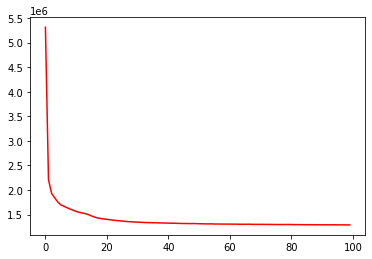

In [714]:
plt.plot(range(len(ELBO)), ELBO, 'r')

In [398]:
# torch.save(vae, '/home/0753115/data/DL_HW2/vae.pkl')
# vae = torch.load('/home/0753115/data/DL_HW2/vae.pkl')

/home/0753115/.local/lib/python3.6/site-packages/torch/serialization.py:402: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [855]:
testset = ImageFolder('/home/0753115/data/DL_HW2/test/',transform=preprocess)
test_data=torch.utils.data.DataLoader(testset, batch_size=16, num_workers=1, shuffle=False)

In [856]:
vae.eval()
with torch.no_grad():
    out=[]
    inimg=[]
    latent_codes=[]
    for data in test_data:
        inputs, _ = data
        prediction,z,_,_ = vae(inputs)   
        latent_codes.append(z)
    for i in range(16):    
        out.append(np.transpose(((prediction[i].detach().numpy())*255),(1,2,0)))
        inimg.append(np.transpose(((inputs[i].detach().numpy())*255),(1,2,0)))

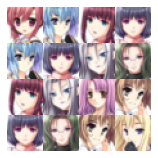

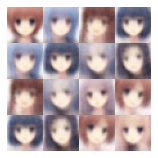

In [857]:
#秀出原始圖片與重構後的結果

f, axarr = plt.subplots(4,4, figsize=(2,2))
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(Image.fromarray(inimg[(i+1)*(j+1)-1].astype(np.uint8)))
        axarr[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

f, axarr = plt.subplots(4,4, figsize=(2,2))
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(Image.fromarray(out[(i+1)*(j+1)-1].astype(np.uint8)))
        axarr[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

In [933]:
img1=latent_codes[0][0]
img2=latent_codes[0][14]
delta=img2-img1
latent_code=[]

for i in range(11):
    latent_code.append(img1+delta/10*i)

In [934]:
vae.eval()
latent_img=[]
with torch.no_grad():
    for code in latent_code:
        z = vae.decode(code)
        latent_img.append(((np.transpose(z[0].detach().numpy(),(1,2,0))*255)).astype(np.uint8))

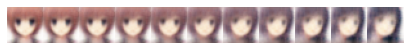

In [935]:
#Show the synthesized images based on the interpolation of two latent codes z between two real samples

f, axarr = plt.subplots(1,11, figsize=(5.5,0.5))
for i in range(11):
        axarr[i].imshow(Image.fromarray(latent_img[i].astype(np.uint8)))
        axarr[i].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

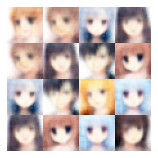

In [819]:
#Sample the prior p(z) and use the latent codes z to synthesize some examples

simulate=[]
with torch.no_grad():
    for i in range(16):
#         sample = torch.empty((1,3,28,28)).uniform_(0,1)
#         mean, var = vae.encode(sample)
#         z = vae.sample_code(mean, var)
        z = torch.empty((1,64)).normal_(mean=0.5,std=2)
        z = vae.decode(z)
        simulate.append(((np.transpose(z[0].detach().numpy(),(1,2,0))*255)).astype(np.uint8))
        
f, axarr = plt.subplots(4,4, figsize=(2,2))
for i in range(4):
    for j in range(4):
        axarr[i, j].imshow(Image.fromarray(simulate[(i+1)*(j+1)-1].astype(np.uint8)))
        axarr[i, j].axis('off')
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()
        
